# Calibration notebook for the autoalignment project

The calibration of the PSD voltages needs to be perform before hand. Based on the design of the board, each channel may have a different voltage offset.
The numbers should be read out from the ADC when the PSD is completely in the dark.

These numbers are filled in the cell below.

In [1]:
p1_x1_offset = 0
p1_x2_offset = 64
p1_y1_offset = 3102
p1_y2_offset = 3085

p2_x1_offset = 0
p2_x2_offset = 0
p2_y1_offset = 3126
p2_y2_offset = 3179

## Utilty functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress

def quotient_err(x1, x2, var1, var2):
    sum_square = var1 + var2
    _sum = x1 + x2
    _sub = x1 - x2
    if _sub == 0:
        return 0
    x = _sub / _sum
    err = np.abs(x * np.sqrt(sum_square * (1 / _sum**2 + 1 / _sub**2)))
    
    return err

def load_motor_data_file(file):
    with open(file, "r") as f:
        data = {
            "ts": [],
            "motor": [],
            "p1_x1s": [],
            "p1_x2s": [],
            "p1_y1s": [],
            "p1_y2s": [],
            "p1_err_x1s": [],
            "p1_err_x2s": [],
            "p1_err_y1s": [],
            "p1_err_y2s": [],
            "p2_x1s": [],
            "p2_x2s": [],
            "p2_y1s": [],
            "p2_y2s": [],
            "p2_err_x1s": [],
            "p2_err_x2s": [],
            "p2_err_y1s": [],
            "p2_err_y2s": [],
            "x1": [],
            "y1": [],
            "x2": [],
            "y2": [],
            "err_x1": [],
            "err_y1": [],
            "err_x2": [],
            "err_y2": []
        }
        
        time1 = 0
        motor1 = 0

        for line in f:
            _, pos, r, time, x1, x2, y1, y2, err_x1, err_x2, err_y1, err_y2 = line.split()

            if r == "r1":
                time1 = int(time)
                motor1 = int(pos)
                data["ts"].append(datetime.fromtimestamp(int(time)))
                data["motor"].append(int(pos))
                data["p1_x1s"].append(int(x1))
                data["p1_x2s"].append(int(x2))
                data["p1_y1s"].append(int(y1))
                data["p1_y2s"].append(int(y2))
                data["p1_err_x1s"].append(int(err_x1))
                data["p1_err_x2s"].append(int(err_x2))
                data["p1_err_y1s"].append(int(err_y1))
                data["p1_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p1_x1_offset
                x2_ = int(x2) - p1_x2_offset
                y1_ = int(y1) - p1_y1_offset
                y2_ = int(y2) - p1_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x1"].append(x)
                data["y1"].append(y)
                data["err_x1"].append(err_x)
                data["err_y1"].append(err_y)
                
            elif r == "r2":
                # if not int(time) == time1:
                #     print("Mismatched timestamp between P1 and P2")
                #     continue
                #     
                # if not int(pos) == motor1:
                #     print("Mismatched motor position between P1 and P2")
                #     continue
                    
                data["p2_x1s"].append(int(x1))
                data["p2_x2s"].append(int(x2))
                data["p2_y1s"].append(int(y1))
                data["p2_y2s"].append(int(y2))
                data["p2_err_x1s"].append(int(err_x1))
                data["p2_err_x2s"].append(int(err_x2))
                data["p2_err_y1s"].append(int(err_y1))
                data["p2_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p2_x1_offset
                x2_ = int(x2) - p2_x2_offset
                y1_ = int(y1) - p2_y1_offset
                y2_ = int(y2) - p2_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x2"].append(x)
                data["y2"].append(y)
                data["err_x2"].append(err_x)
                data["err_y2"].append(err_y)
        
        for key in data.keys():
            data[key] = np.array(data[key])
            
        return data

def time_window(arr, window, ts):
    return np.asarray(arr)[(np.asarray(ts) < window[1]) & (np.asarray(ts) > window[0])]

def plot_p1_p2(data, sep=120):
    display_window = (data["ts"][0], data["ts"][-1])

    plt.figure(figsize=(15, 10))

    plt.subplot(211)
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_x1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_x1s"], display_window, data["ts"]))[::sep], color="b", label="p1_x1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_x1s"], display_window, data["ts"]), color="b", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_x2s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_x2s"], display_window, data["ts"]))[::sep], color="r", label="p1_x2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_x2s"], display_window, data["ts"]), color="r", linewidth=2)
    
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_x1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_x1s"], display_window, data["ts"]))[::sep], color="darkviolet", label="p2_x1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_x1s"], display_window, data["ts"]), color="darkviolet", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_x2s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_x2s"], display_window, data["ts"]))[::sep], color="deeppink", label="p2_x2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_x2s"], display_window, data["ts"]), color="deeppink", linewidth=2)

    plt.title("P1 & P2")
    plt.ylim(0, 4096)
    plt.legend()

    plt.subplot(212)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_y1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_y1s"], display_window, data["ts"]))[::sep], color="orange", label="p1_y1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_y1s"], display_window, data["ts"]), color="orange", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_y2s"], display_window, data["ts"])[::sep],
                 yerr=np.sqrt(time_window(data["p1_err_y2s"], display_window, data["ts"]))[::sep], color="green", label="p1_y2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_y2s"], display_window, data["ts"]), color="green", linewidth=2)
    
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_y1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_y1s"], display_window, data["ts"]))[::sep], color="dodgerblue", label="p2_y1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_y1s"], display_window, data["ts"]), color="dodgerblue", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_y2s"], display_window, data["ts"])[::sep],
                 yerr=np.sqrt(time_window(data["p2_err_y2s"], display_window, data["ts"]))[::sep], color="crimson", label="p2_y2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_y2s"], display_window, data["ts"]), color="crimson", linewidth=2)
    plt.title("P1 & P2")
    plt.ylim(0, 4096)
    plt.legend()
    
    plt.plot()

def plot_motor(data):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.title("P1")
    plt.plot(data["motor"], data["x1"], label="x1")
    plt.plot(data["motor"], data["y1"], label="y1")
    #plt.errorbar(data["motor"], data["x1"], yerr=data["err_x1"], label="x1")
    #plt.errorbar(data["motor"], data["y1"], yerr=data["err_y1"], label="y1")

    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("P2")
    plt.plot(data["motor"], data["x2"], label="x2")
    plt.plot(data["motor"], data["y2"], label="y2")
    #plt.errorbar(data["motor"], data["x2"], yerr=data["err_x2"], label="x2")
    #plt.errorbar(data["motor"], data["y2"], yerr=data["err_y2"], label="y2")

    plt.legend()

def merge_seg_dict(segs):
    data = {}
    
    for k in segs[0].keys():
        data[k] = []
        for seg in segs:
            data[k] += list(seg[k])
    
    return data

def filter_data_by_cond(data, cond):
    new_data = {}
    for key, val in data.items():
        new_data[key] = np.asarray(val)[cond]
    
    return new_data

def segmentate(arr, det=20):
    seg_end = []
    seg_start = [0]
    det = abs(det)
    
    dir_ctr = 5
    
    before_change_ind = 0
    before_change_dir = 1
    
    for i in range(len(arr)-10):
        dir_ctr += 1 if arr[i+10] > arr[i] else -1
        
        if dir_ctr > det:
            dir_ctr = det
            if i - before_change_ind > det and before_change_dir == -1:
                seg_end.append(before_change_ind)
                seg_start.append(i)
                
            before_change_ind = i
            before_change_dir = 1
        elif dir_ctr < -det:
            dir_ctr = -det
            if i - before_change_ind > det and before_change_dir == 1:
                seg_end.append(before_change_ind)
                seg_start.append(i)
                
            before_change_ind = i
            before_change_dir = -1
        else:
            continue
    
    seg_end.append(len(arr)-1)
    
    return list(zip(seg_start, seg_end))

def fit_m_to_p_vector(data):
    exts = [max(data["x1"]) - min(data["x1"]),
            max(data["y1"]) - min(data["y1"]),
            max(data["x2"]) - min(data["x2"]),
            max(data["y2"]) - min(data["y2"])]
    
    ext_axis = ["x1", "y1", "x2", "y2"][np.argmax(exts)]
    
    seg = segmentate(data[ext_axis], 15)
    seg = seg[1:]
    
    k_ps = {"x1": [], "y1": [], "x2": [], "y2": []}
    k_ns = {"x1": [], "y1": [], "x2": [], "y2": []}
    
    for i, (s, e) in enumerate(seg):
        motor_seg = data["motor"][s:e]
        
        k_s = k_ps
        if motor_seg[-1] < motor_seg[0]:
            k_s = k_ns
        
        for axis in ["x1", "y1", "x2", "y2"]:
            k, b, r, p, se = linregress(motor_seg, data[axis][s:e])
            k_s[axis].append(k)

    k_avg_p = { key: np.average(arr) for key, arr in k_ps.items() }
    k_avg_n = { key: np.average(arr) for key, arr in k_ns.items() }

    return k_avg_p, k_avg_n

def fit_seg_m_to_p_vector(data_seg):
    k_ps = {"x1": [], "y1": [], "x2": [], "y2": []}
    k_ns = {"x1": [], "y1": [], "x2": [], "y2": []}
    
    for i, data in enumerate(data_seg):
        motor_seg = data["motor"]
        
        k_s = k_ps
        if motor_seg[-1] < motor_seg[0]:
            k_s = k_ns
        
        for axis in ["x1", "y1", "x2", "y2"]:
            k, b, r, p, se = linregress(motor_seg, data[axis])
            k_s[axis].append(k)

    k_avg_p = { key: np.average(arr) for key, arr in k_ps.items() }
    k_avg_n = { key: np.average(arr) for key, arr in k_ns.items() }

    return k_avg_p, k_avg_n

## Calibrating the PSD response of motors

The response of the beam position on PSDs are denoted by a $p$-vector, which constitutes a column of the inversed $A$-matrix.

### Calibration motor M1

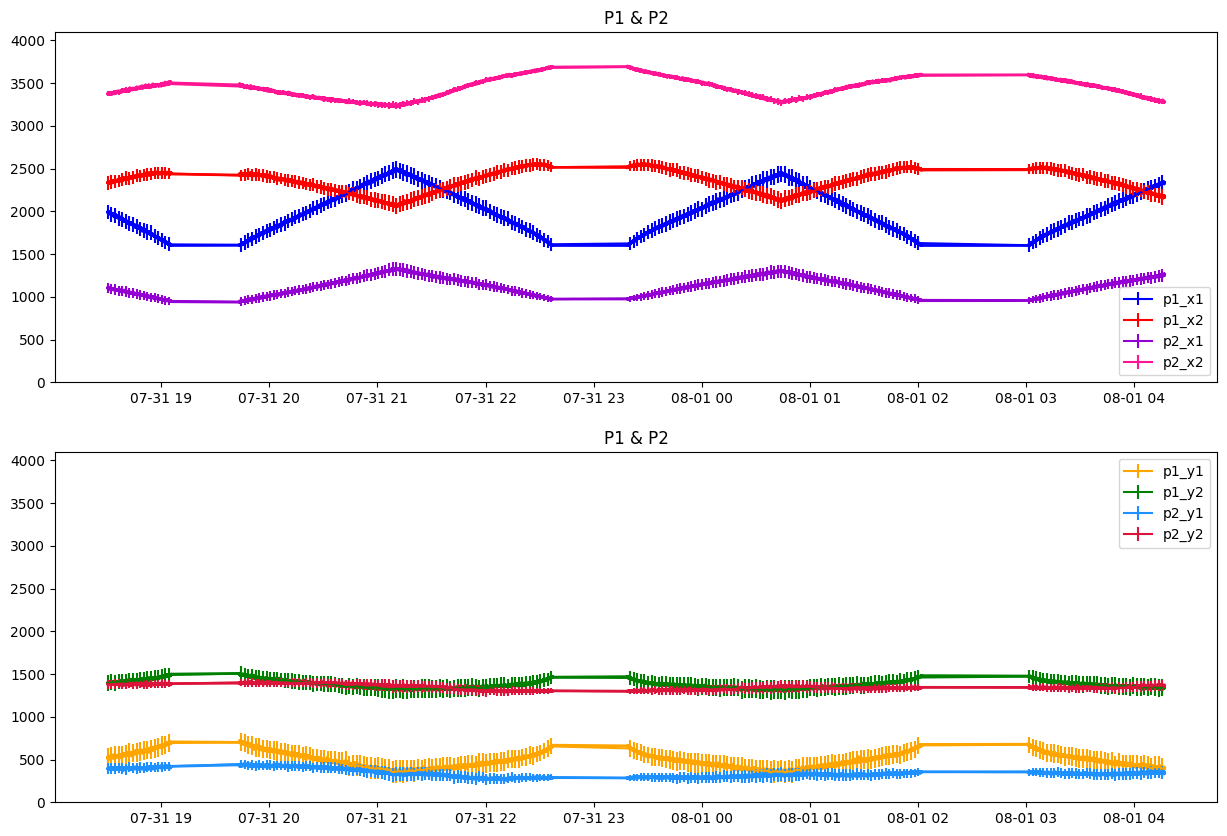

In [4]:
data = load_motor_data_file("2022-07-31_m1.txt")

data = filter_data_by_cond(data, np.asarray(data['p1_x1s']) > 1600)

plot_p1_p2(data)

In [5]:
seg = segmentate(data["x1"], 15)

seg

[(0, 0),
 (76, 2067),
 (2216, 7319),
 (7478, 12501),
 (12584, 17634),
 (17749, 22301),
 (22444, 26835)]

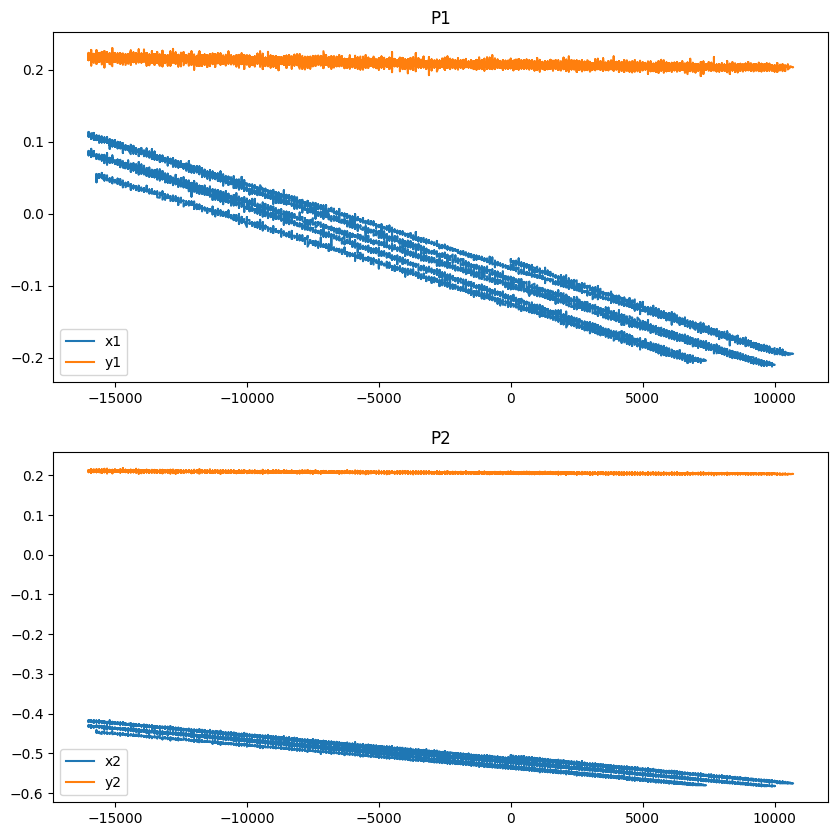

In [6]:
plot_motor(data)

seg1 kx1=-1.249e-05 ky1=-6.197e-07 kx2=-6.329e-06 ky2=-3.373e-07
seg2 kx1=-1.161e-05 ky1=-6.332e-07 kx2=-5.946e-06 ky2=-3.021e-07
seg3 kx1=-1.243e-05 ky1=-6.112e-07 kx2=-6.334e-06 ky2=-3.103e-07
seg4 kx1=-1.157e-05 ky1=-5.847e-07 kx2=-5.903e-06 ky2=-2.993e-07
seg5 kx1=-1.251e-05 ky1=-6.256e-07 kx2=-6.370e-06 ky2=-3.320e-07
seg6 kx1=-1.147e-05 ky1=-5.795e-07 kx2=-5.852e-06 ky2=-2.977e-07


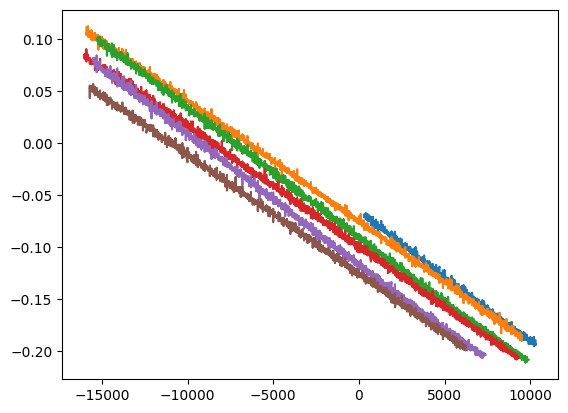

In [7]:
from scipy.stats import linregress
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["x1"][s:e], label=f"x1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [8]:
m1_a_p, m1_a_n = fit_m_to_p_vector(data)

### Calibration motor M2

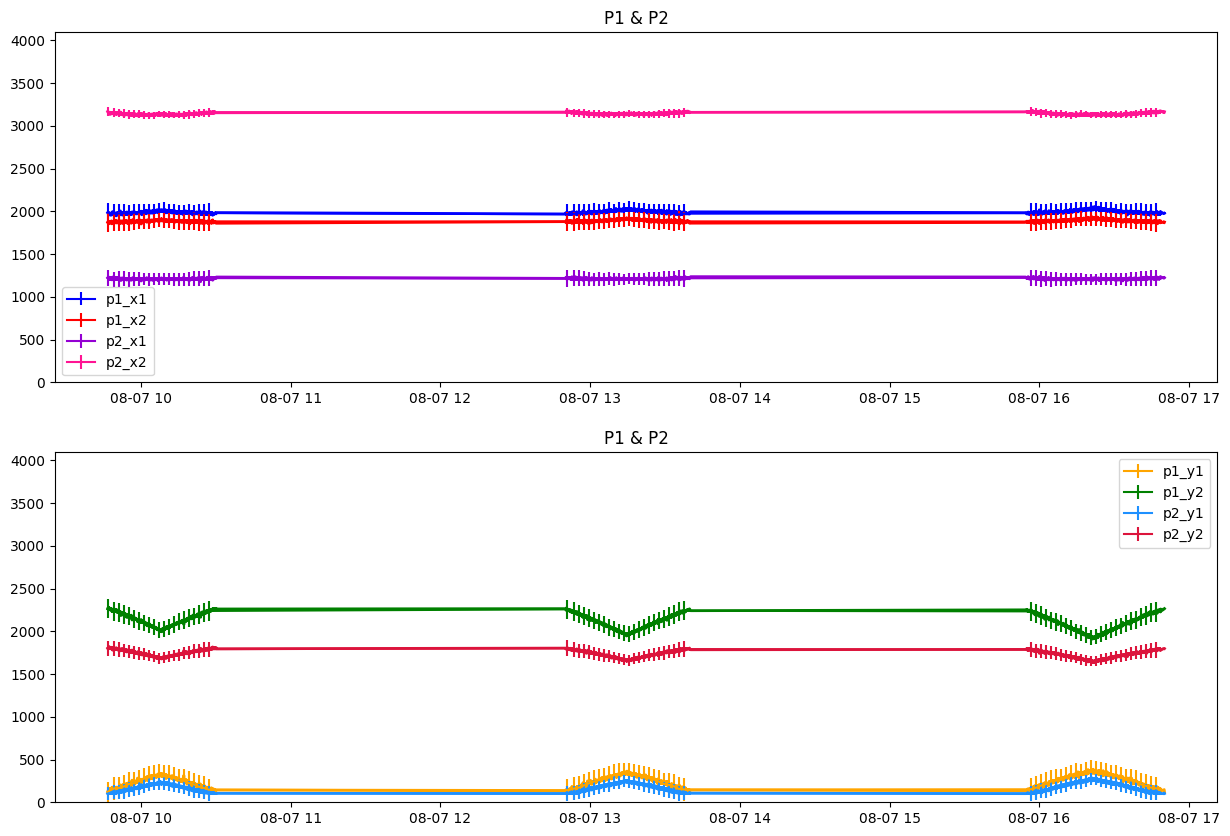

In [9]:
data = load_motor_data_file("2022-08-07_m2.txt")

data = filter_data_by_cond(data, np.asarray(data['p2_y1s']) > 100)

plot_p1_p2(data)

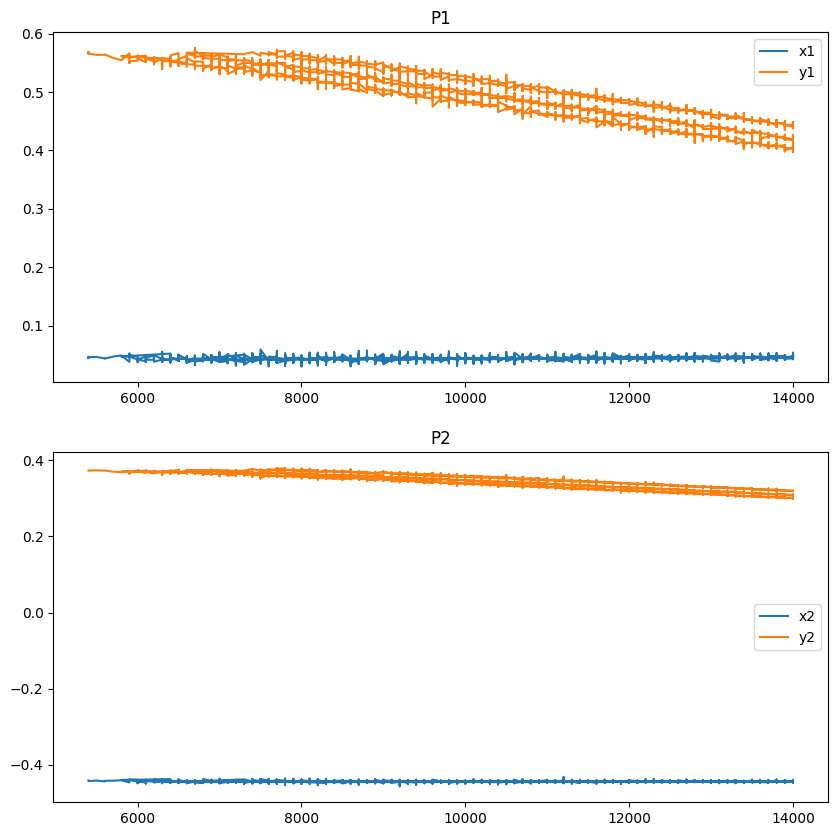

In [10]:
plot_motor(data)

In [11]:
seg = segmentate(data["y1"], 15)

seg

[(0, 0),
 (64, 1247),
 (1378, 2501),
 (2556, 3904),
 (3975, 5338),
 (5399, 6878),
 (6957, 8484)]

seg1 kx1=4.794e-07 ky1=-2.052e-05 kx2=4.160e-08 ky2=-9.330e-06
seg2 kx1=4.059e-07 ky1=-1.938e-05 kx2=5.026e-08 ky2=-8.694e-06
seg3 kx1=4.789e-07 ky1=-2.034e-05 kx2=2.225e-08 ky2=-9.302e-06
seg4 kx1=4.482e-07 ky1=-1.963e-05 kx2=7.495e-09 ky2=-8.905e-06
seg5 kx1=4.938e-07 ky1=-2.026e-05 kx2=-2.447e-08 ky2=-9.305e-06
seg6 kx1=4.712e-07 ky1=-1.967e-05 kx2=-2.792e-08 ky2=-8.944e-06


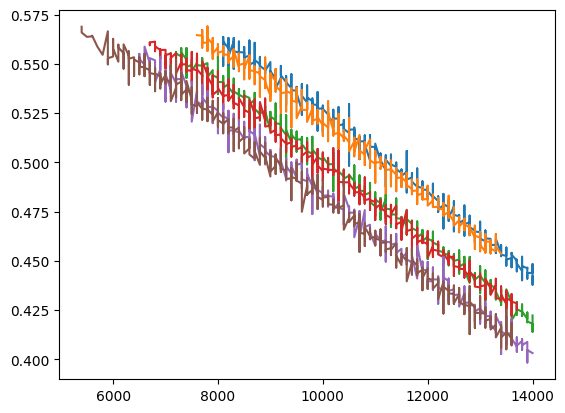

In [12]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["y1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [13]:
m2_a_p, m2_a_n = fit_m_to_p_vector(data)

### Calibration motor M3

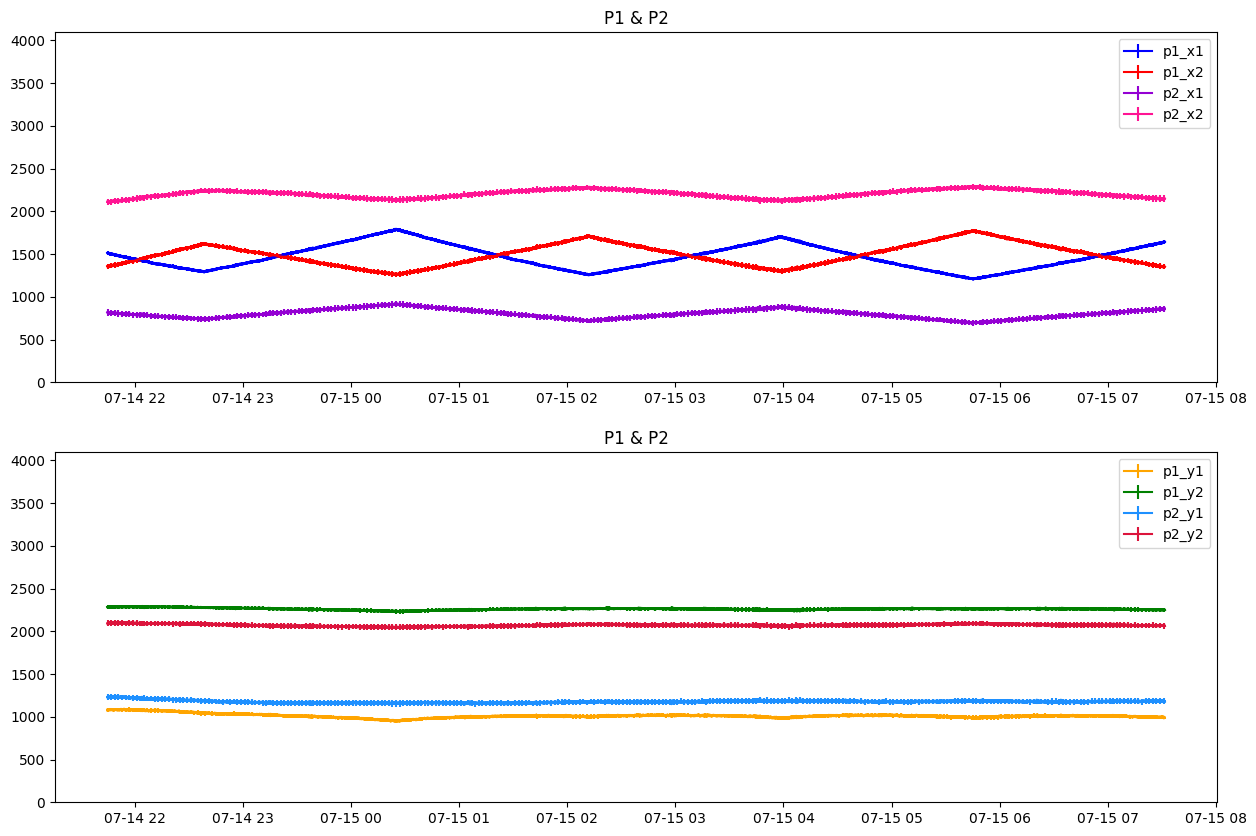

In [14]:
data = load_motor_data_file("2022-07-14_m3.txt")

plot_p1_p2(data)

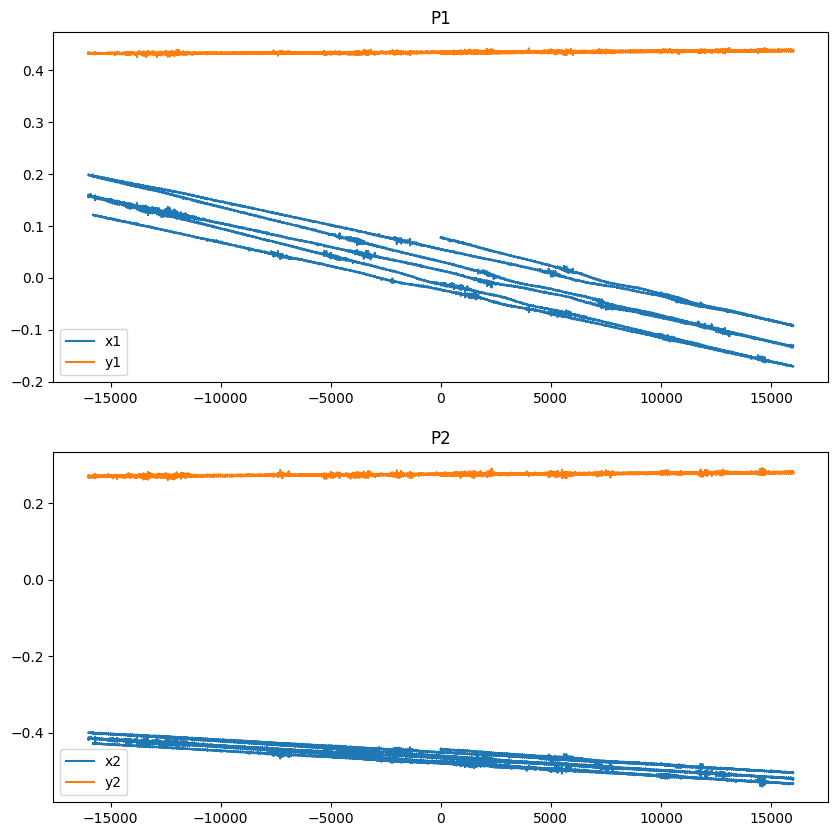

In [15]:
plot_motor(data)

In [16]:
seg = segmentate(data["x1"], 15)

seg

[(0, 0),
 (60, 3202),
 (3275, 9613),
 (9672, 16013),
 (16084, 22419),
 (22508, 28829),
 (28878, 35191)]

seg1 kx1=-1.067e-05 ky1=3.028e-07 kx2=-3.854e-06 ky2=3.941e-07
seg2 kx1=-9.163e-06 ky1=1.547e-07 kx2=-3.295e-06 ky2=3.073e-07
seg3 kx1=-1.044e-05 ky1=2.187e-07 kx2=-3.767e-06 ky2=3.600e-07
seg4 kx1=-9.103e-06 ky1=1.811e-07 kx2=-3.281e-06 ky2=3.129e-07
seg5 kx1=-1.029e-05 ky1=2.417e-07 kx2=-3.714e-06 ky2=3.546e-07
seg6 kx1=-9.182e-06 ky1=1.990e-07 kx2=-3.312e-06 ky2=3.072e-07


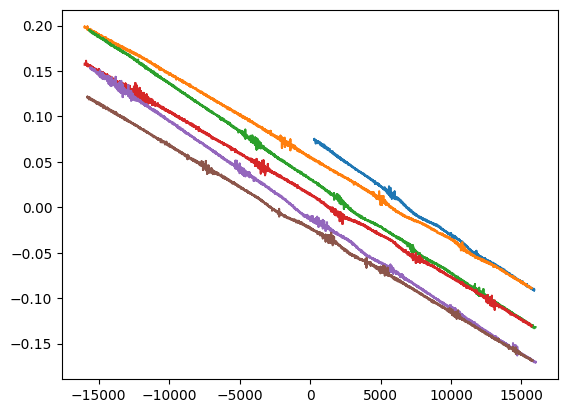

In [17]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["x1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [18]:
m3_a_p, m3_a_n = fit_m_to_p_vector(data)

### Calibration motor M4

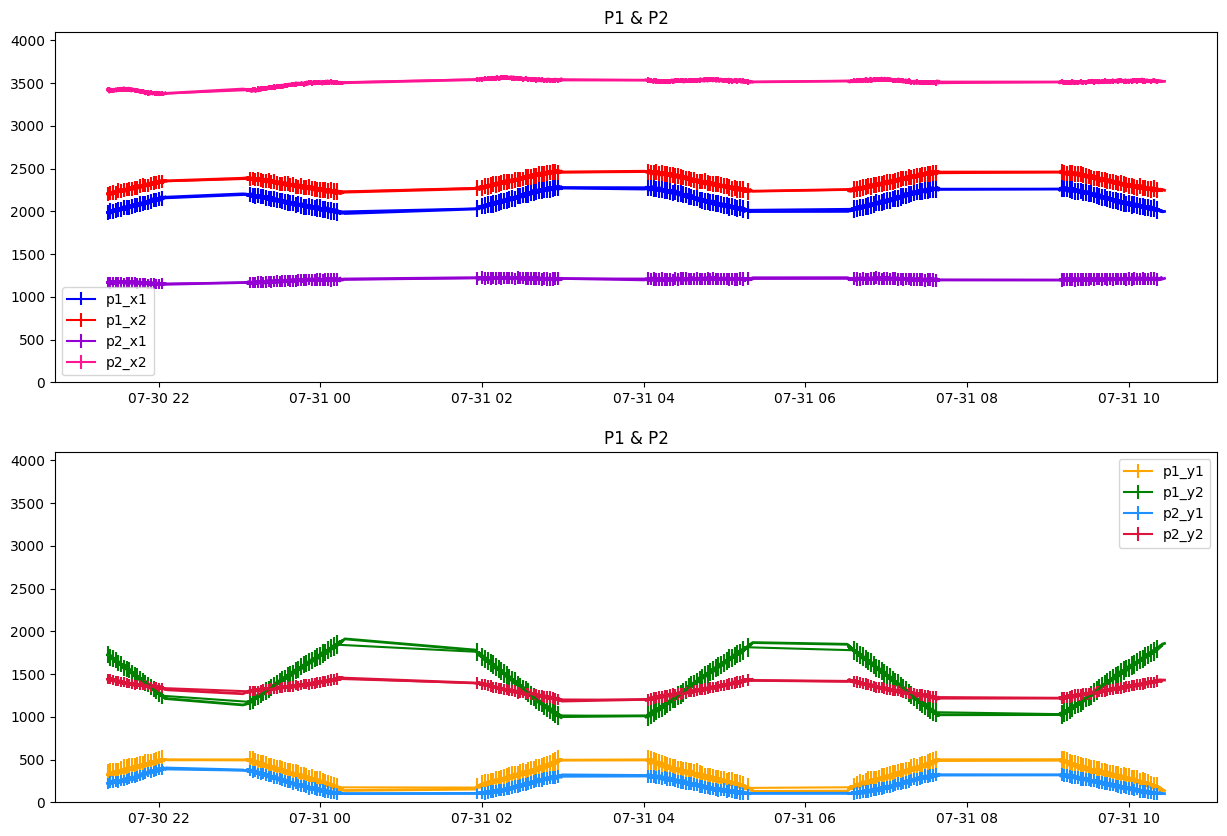

In [19]:
data = load_motor_data_file("2022-07-30_m4.txt")

data = filter_data_by_cond(data, np.asarray(data['p1_y1s']) < 500)
data = filter_data_by_cond(data, np.asarray(data['p2_y1s']) > 100)

plot_p1_p2(data)

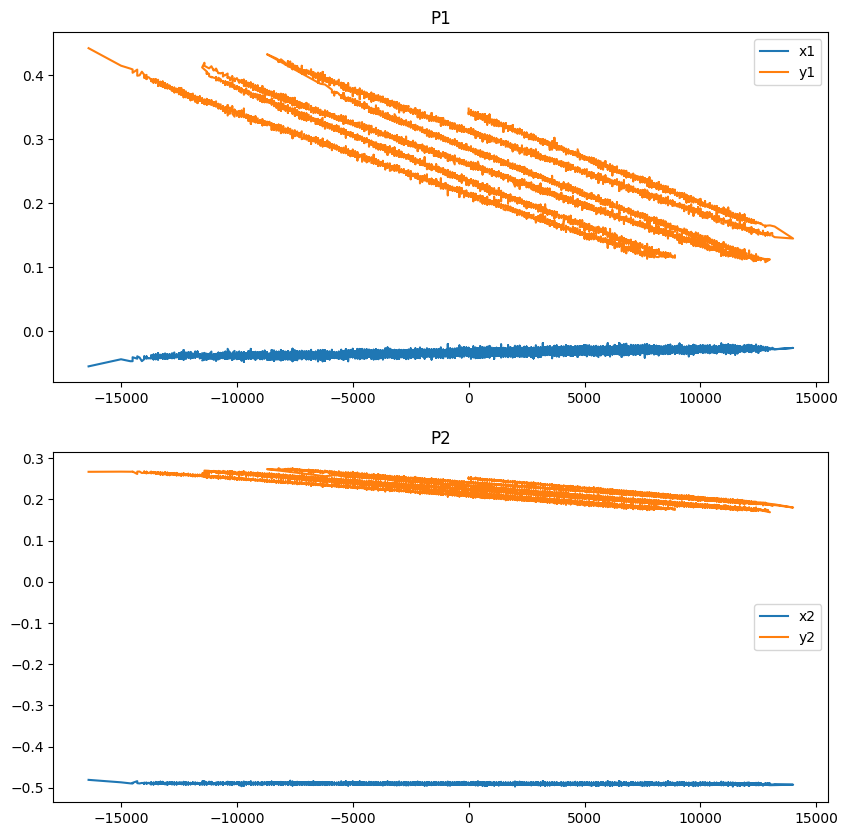

In [20]:
plot_motor(data)

In [21]:
seg = segmentate(data["y1"], 15)

seg

[(0, 0),
 (60, 2461),
 (2554, 6468),
 (6515, 10048),
 (10173, 14420),
 (14457, 18211),
 (18334, 22500)]

seg1 kx1=6.294e-07 ky1=-1.409e-05 kx2=-5.656e-08 ky2=-4.667e-06
seg2 kx1=5.897e-07 ky1=-1.286e-05 kx2=-7.850e-08 ky2=-4.168e-06
seg3 kx1=7.208e-07 ky1=-1.406e-05 kx2=-4.702e-08 ky2=-4.607e-06
seg4 kx1=6.451e-07 ky1=-1.274e-05 kx2=-4.761e-08 ky2=-4.155e-06
seg5 kx1=6.945e-07 ky1=-1.413e-05 kx2=-5.473e-08 ky2=-4.611e-06
seg6 kx1=6.392e-07 ky1=-1.271e-05 kx2=-4.523e-08 ky2=-4.135e-06


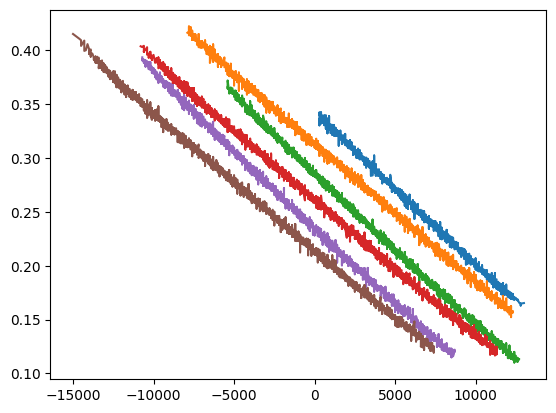

In [22]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["y1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [23]:
m4_a_p, m4_a_n = fit_m_to_p_vector(data)

### Analyzing fitting errors

In [24]:
import statsmodels.api as sm

ms = data["motor"][seg[0][0]: seg[0][1]]
ys = data["x1"][seg[0][0]: seg[0][1]]
y_errs = data["err_x1"][seg[0][0]: seg[0][1]]
y_errs[y_errs < 1e-9] = 0.001

ms = sm.add_constant(ms)

mod_wls = sm.WLS(ys, ms, 1/y_errs**2)
res_wls = mod_wls.fit()

print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            WLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     4577.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:50:54   Log-Likelihood:                 12076.
No. Observations:                2401   AIC:                        -2.415e+04
Df Residuals:                    2399   BIC:                        -2.414e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0377   6.92e-05   -544.559      0.0

In [25]:
mod_ols = sm.OLS(ys, ms)
res_ols = mod_ols.fit()

print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     4547.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:50:55   Log-Likelihood:                 12071.
No. Observations:                2401   AIC:                        -2.414e+04
Df Residuals:                    2399   BIC:                        -2.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0377   6.67e-05   -564.911      0.0

## Construct M-Matrix (inversed A-matrix) from p-vectors

In [26]:
# Column vectors of A

m1_a_p_col = np.array([m1_a_p["x1"], m1_a_p["y1"], m1_a_p["x2"], m1_a_p["y2"]])
m2_a_p_col = np.array([m2_a_p["x1"], m2_a_p["y1"], m2_a_p["x2"], m2_a_p["y2"]])
m3_a_p_col = np.array([m3_a_p["x1"], m3_a_p["y1"], m3_a_p["x2"], m3_a_p["y2"]])
m4_a_p_col = np.array([m4_a_p["x1"], m4_a_p["y1"], m4_a_p["x2"], m4_a_p["y2"]])

m1_a_n_col = np.array([m1_a_n["x1"], m1_a_n["y1"], m1_a_n["x2"], m1_a_n["y2"]])
m2_a_n_col = np.array([m2_a_n["x1"], m2_a_n["y1"], m2_a_n["x2"], m2_a_n["y2"]])
m3_a_n_col = np.array([m3_a_n["x1"], m3_a_n["y1"], m3_a_n["x2"], m3_a_n["y2"]])
m4_a_n_col = np.array([m4_a_n["x1"], m4_a_n["y1"], m4_a_n["x2"], m4_a_n["y2"]])


# filtering
# m1_a_p_col[abs(m1_a_p_col) < 1e-6] = 0
# m2_a_p_col[abs(m2_a_p_col) < 1e-6] = 0
# m3_a_p_col[abs(m3_a_p_col) < 1e-6] = 0
# m4_a_p_col[abs(m4_a_p_col) < 1e-6] = 0
# m1_a_n_col[abs(m1_a_n_col) < 1e-6] = 0
# m2_a_n_col[abs(m2_a_n_col) < 1e-6] = 0
# m3_a_n_col[abs(m3_a_n_col) < 1e-6] = 0
# m4_a_n_col[abs(m4_a_n_col) < 1e-6] = 0


# 16 matrices

Mpppp = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mpppn = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mppnp = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mpnpp = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnppp = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mppnn = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnpn = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mpnnp = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnppn = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnp = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpp = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnnnp = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpn = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnn = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnnn = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()
Mnnnn = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()

In [27]:
Mpppp

array([[-1.24795836e-05,  4.84067060e-07, -1.04675905e-05,
         6.81566042e-07],
       [-6.18843005e-07, -2.03725171e-05,  2.54387555e-07,
        -1.40951818e-05],
       [-6.34461814e-06,  1.31252801e-08, -3.77853698e-06,
        -5.27683524e-08],
       [-3.26505038e-07, -9.31254890e-06,  3.69581025e-07,
        -4.62812284e-06]])

In [28]:
from numpy.linalg import inv

Apppp = inv(Mpppp)
Apppn = inv(Mpppn)
Appnp = inv(Mppnp)
Apnpp = inv(Mpnpp)
Anppp = inv(Mnppp)
Appnn = inv(Mppnn)
Apnpn = inv(Mpnpn)
Apnnp = inv(Mpnnp)
Anppn = inv(Mnppn)
Anpnp = inv(Mnpnp)
Annpp = inv(Mnnpp)
Annnp = inv(Mnnnp)
Annpn = inv(Mnnpn)
Anpnn = inv(Mnpnn)
Apnnn = inv(Mpnnn)
Annnn = inv(Mnnnn)

In [29]:
Apppp

array([[ 192015.84490119,   29320.89300547, -535334.3620723 ,
         -54917.10885759],
       [ -44276.18557879,  118838.04783329,   94514.4558715 ,
        -369525.28372418],
       [-323265.99746031,  -45401.58150728,  635985.62852174,
          83415.35404189],
       [  49730.10265187, -244815.91188302, -101624.98310346,
         538011.15572848]])

### Verification of the calbration

Try to use the fit to reproduce the original data.

In [32]:
def m_matrix_select(m_vec):
    cand = np.array([Mpppp, Mpppn, Mppnp, Mppnn, Mpnpp, Mpnpn, Mpnnp, Mpnnn,
                     Mnppp, Mnppn, Mnpnp, Mnpnn, Mnnpp, Mnnpn, Mnnnp, Mnnnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

def a_matrix_select(m_vec):
    cand = np.array([Apppp, Apppn, Appnp, Appnn, Apnpp, Apnpn, Apnnp, Apnnn,
                     Anppp, Anppn, Anpnp, Anpnn, Annpp, Annpn, Annnp, Annnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

### Use the fit to reproduce independently-measured new data


| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   |
|------|------|------|------|------|------|-------|------|
| 0    | 0    | 0    | 0    | 0.13 | 0.28 | -0.23 | 0.28 |
| 0    | 5000 | 0    | 0    | 0.14 | 0.19 | -0.23 | 0.23 |
| 5000 | 5000 | 0    | 0    | 0.08 | 0.19 | -0.26 | 0.23 |
| 5000 | 5000 | 5000 | 0    | 0.04 | 0.19 | -0.28 | 0.23 |
| 5000 | 5000 | 5000 | 5000 | 0.04 | 0.13 | -0.28 | 0.21 |
| 0    | 5000 | 5000 | 5000 | 0.09 | 0.13 | -0.25 | 0.21 |
| 0    | 0    | 5000 | 5000 | 0.09 | 0.21 | -0.25 | 0.25 |
| 0    | 0    | 0    | 5000 | 0.13 | 0.21 | -0.24 | 0.25 |
| 0    | 0    | 0    | 0    | 0.12 | 0.27 | -0.24 | 0.27 |

- `m1`: Commanded motor steps
- `x1`: Measured beam position
- `x1_c`: Calculated beam position from the fit
- `ex1`: Error between the measurament and the fit

See the table under the next cell.

In [33]:
table = """ 0    | 0    | 0    | 0    | 0.13 | 0.28 | -0.23 | 0.28
0    | 5000 | 0    | 0    | 0.14 | 0.19 | -0.23 | 0.23
5000 | 5000 | 0    | 0    | 0.08 | 0.19 | -0.26 | 0.23
5000 | 5000 | 5000 | 0    | 0.04 | 0.19 | -0.28 | 0.23
5000 | 5000 | 5000 | 5000 | 0.04 | 0.13 | -0.28 | 0.21
0    | 5000 | 5000 | 5000 | 0.09 | 0.13 | -0.25 | 0.21
0    | 0    | 5000 | 5000 | 0.09 | 0.21 | -0.25 | 0.25
0    | 0    | 0    | 5000 | 0.13 | 0.21 | -0.24 | 0.25
0    | 0    | 0    | 0    | 0.12 | 0.27 | -0.24 | 0.27"""

m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs = [], [] ,[], [], [], [], [], []
for line in table.split("\n"):
    [arr.append(float(val)) for val, arr in zip(line.split("|"), [m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs])]

x1_cs, y1_cs, x2_cs, y2_cs = [], [] ,[], []
x1_cs.append(x1_rs[0])
y1_cs.append(y1_rs[0])
x2_cs.append(x2_rs[0])
y2_cs.append(y2_rs[0])

for i in range(1, len(m1_rs)):
    _delta_m_vec = np.array([m1_rs[i] - m1_rs[i-1],  m2_rs[i] - m2_rs[i-1], m3_rs[i] - m3_rs[i-1], m4_rs[i] - m4_rs[i-1]])
    _delta_x_vec_cal = m_matrix_select(_delta_m_vec) @ _delta_m_vec 
    
    _x_vec = np.array([x1_cs[i-1], y1_cs[i-1], x2_cs[i-1], y2_cs[i-1]]) + _delta_x_vec_cal
    
    [arr.append(float(val)) for val, arr in zip(_x_vec, [x1_cs, y1_cs, x2_cs, y2_cs])]

x1_diffs, y1_diffs, x2_diffs, y2_diffs = np.asarray(x1_cs) - np.asarray(x1_rs), np.asarray(y1_cs) - np.asarray(y1_rs), np.asarray(x2_cs) - np.asarray(x2_rs), np.asarray(y2_cs) - np.asarray(y2_rs) 

table = """| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
"""
for arr in zip(m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs, x1_cs, y1_cs, x2_cs, y2_cs, x1_diffs, y1_diffs, x2_diffs, y2_diffs):
    table += " | ".join([f"{a:.2f}" for a in arr])
    table += "|\n"

from IPython.display import display, Markdown
display(Markdown(table))

| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
0.00 | 0.00 | 0.00 | 0.00 | 0.13 | 0.28 | -0.23 | 0.28 | 0.13 | 0.28 | -0.23 | 0.28 | 0.00 | 0.00 | 0.00 | 0.00|
0.00 | 5000.00 | 0.00 | 0.00 | 0.14 | 0.19 | -0.23 | 0.23 | 0.13 | 0.18 | -0.23 | 0.23 | -0.01 | -0.01 | 0.00 | 0.00|
5000.00 | 5000.00 | 0.00 | 0.00 | 0.08 | 0.19 | -0.26 | 0.23 | 0.07 | 0.18 | -0.26 | 0.23 | -0.01 | -0.01 | -0.00 | 0.00|
5000.00 | 5000.00 | 5000.00 | 0.00 | 0.04 | 0.19 | -0.28 | 0.23 | 0.02 | 0.18 | -0.28 | 0.23 | -0.02 | -0.01 | -0.00 | 0.00|
5000.00 | 5000.00 | 5000.00 | 5000.00 | 0.04 | 0.13 | -0.28 | 0.21 | 0.02 | 0.11 | -0.28 | 0.21 | -0.02 | -0.02 | -0.00 | 0.00|
0.00 | 5000.00 | 5000.00 | 5000.00 | 0.09 | 0.13 | -0.25 | 0.21 | 0.08 | 0.11 | -0.25 | 0.21 | -0.01 | -0.02 | -0.00 | 0.00|
0.00 | 0.00 | 5000.00 | 5000.00 | 0.09 | 0.21 | -0.25 | 0.25 | 0.08 | 0.21 | -0.25 | 0.26 | -0.01 | -0.00 | -0.00 | 0.01|
0.00 | 0.00 | 0.00 | 5000.00 | 0.13 | 0.21 | -0.24 | 0.25 | 0.12 | 0.21 | -0.23 | 0.25 | -0.01 | -0.00 | 0.01 | 0.00|
0.00 | 0.00 | 0.00 | 0.00 | 0.12 | 0.27 | -0.24 | 0.27 | 0.12 | 0.27 | -0.23 | 0.28 | -0.00 | -0.00 | 0.01 | 0.01|


## Code generation

The below cells generate the part of the `BeamPositionMatrix.h`.

In [34]:
combs = [
    ('P', 'P', 'P', 'P', Apppp),
    ('P', 'P', 'P', 'N', Apppn),
    ('P', 'P', 'N', 'P', Appnp),
    ('P', 'P', 'N', 'N', Appnn),
    ('P', 'N', 'P', 'P', Apnpp),
    ('P', 'N', 'P', 'N', Apnpn),
    ('P', 'N', 'N', 'P', Apnnp),
    ('P', 'N', 'N', 'N', Apnnn),
    ('N', 'P', 'P', 'P', Anppp),
    ('N', 'P', 'P', 'N', Anppn),
    ('N', 'P', 'N', 'P', Anpnp),
    ('N', 'P', 'N', 'N', Anpnn),
    ('N', 'N', 'P', 'P', Annpp),
    ('N', 'N', 'P', 'N', Annpn),
    ('N', 'N', 'N', 'P', Annnp),
    ('N', 'N', 'N', 'N', Annnn)
]

code = ""
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"""const PositionMotionMatrix POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir} = {{
    {{
        {{ {int(b[0][0]):>7d}, {int(b[0][1]):>7d}, {int(b[0][2]):>7d}, {int(b[0][3]):>7d} }},
        {{ {int(b[1][0]):>7d}, {int(b[1][1]):>7d}, {int(b[1][2]):>7d}, {int(b[1][3]):>7d} }},
        {{ {int(b[2][0]):>7d}, {int(b[2][1]):>7d}, {int(b[2][2]):>7d}, {int(b[2][3]):>7d} }},
        {{ {int(b[3][0]):>7d}, {int(b[3][1]):>7d}, {int(b[3][2]):>7d}, {int(b[3][3]):>7d} }},
    }}
}};
    
"""

In [35]:
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir}, "
print(code)

const PositionMotionMatrix POS_MTR_MTX_P_P_P_P = {
    {
        {  192015,   29320, -535334,  -54917 },
        {  -44276,  118838,   94514, -369525 },
        { -323265,  -45401,  635985,   83415 },
        {   49730, -244815, -101624,  538011 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_P_N = {
    {
        {  191791,   30424, -534876,  -57343 },
        {  -43422,  114637,   92770, -360294 },
        { -323001,  -46704,  635444,   86277 },
        {   53552, -263632, -109436,  579363 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_P = {
    {
        {  190488,   29106, -532329,  -54522 },
        {  -44078,  118865,   94125, -369576 },
        { -367675,  -51638,  723355,   94874 },
        {   50694, -244680, -103522,  537762 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_N = {
    {
        {  190260,   30203, -531864,  -56934 },
        {  -43208,  114668,   92349, -360351 },
        { -367368,  -53119,  722728,   98128 },
        { 